## Imports

In [133]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Flatten
from keras.models import Sequential
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Cleaning and Analysis

In [134]:
data = pd.read_csv("clinical_data.csv")

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6388 entries, 0 to 6387
Data columns (total 74 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   caseid               6388 non-null   int64  
 1   subjectid            6388 non-null   int64  
 2   casestart            6388 non-null   int64  
 3   caseend              6388 non-null   int64  
 4   anestart             6388 non-null   int64  
 5   aneend               6388 non-null   float64
 6   opstart              6388 non-null   int64  
 7   opend                6388 non-null   int64  
 8   adm                  6388 non-null   int64  
 9   dis                  6388 non-null   int64  
 10  icu_days             6388 non-null   int64  
 11  death_inhosp         6388 non-null   int64  
 12  age                  6388 non-null   object 
 13  sex                  6388 non-null   object 
 14  height               6388 non-null   float64
 15  weight               6388 non-null   f

,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,...,0,120,0.0,100,70,0,10,0,0,0
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,...,0,150,0.0,0,100,0,20,0,0,0
2,3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,...,0,0,0.0,0,50,0,0,0,0,0
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,...,0,80,0.0,100,100,0,50,0,0,0
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,...,0,0,0.0,0,160,0,10,900,0,2100


In [135]:
drop_columns = ['subjectid', 'casestart', 'caseend', 'anestart', 
                'aneend', 'opstart', 'opend', 'adm', 'dis', 'dltubesize', 
                'lmasize', 'aline2', 'cline1', 'cline2']

data = data.drop(drop_columns, axis=1)

print(len(data['dx'].unique()))
data.shape

1038


(6388, 60)

### Cleaning Age


In [136]:
# Changing age to float

data['age'] = data['age'].replace(['>89'], '89')

data['age'] = pd.to_numeric(data['age'])
df = data['age'].value_counts().rename_axis('Age').reset_index(name='Count').sort_values(['Age'], ascending=False)

df.tail(10)

data = data[data.age > 1]

data.shape

(6378, 60)

In [137]:
# Chnaging Age to rasnges
df = data['age'].value_counts().rename_axis('Age').reset_index(name='Count').sort_values(['Age'], ascending=False)
df['AgeRange'] = pd.cut(df['Age'], 5)
print(df['AgeRange'].unique())
# df[''].groupby(['AgeRange'], as_index=False).count().sort_values('AgeRange', ascending=True)

data['age'] = np.where((data['age'] >= 4) & (data['age'] < 22), 0, data['age'])
data['age'] = np.where((data['age'] >= 22) & (data['age'] < 39), 1, data['age'])
data['age'] = np.where((data['age'] >= 39) & (data['age'] < 56), 2, data['age'])
data['age'] = np.where((data['age'] >= 56) & (data['age'] < 73), 3, data['age'])
data['age'] = np.where((data['age'] >= 73) & (data['age'] <= 89), 4, data['age'])

# data.loc[(data['age'] >= 22 and data['age'] < 39), 'age'] = 1
# data.loc[(data['age'] >= 39 and data['age'] < 56), 'age'] = 2
# data.loc[(data['age'] >= 56 and data['age'] < 73), 'age'] = 3
# data.loc[(data['age'] >= 73 and data['age'] <= 89), 'age'] = 4

data['age'].value_counts()

[(72.2, 89.0], (55.4, 72.2], (38.6, 55.4], (21.8, 38.6], (4.916, 21.8]]
Categories (5, interval[float64, right]): [(4.916, 21.8] < (21.8, 38.6] < (38.6, 55.4] <
                                           (55.4, 72.2] < (72.2, 89.0]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

3.0    2835
2.0    1772
4.0    1018
1.0     636
0.0     117
Name: age, dtype: int64

### Cleaning Diagnosis Columns

### Select Columns

In [138]:
data.columns

Index(['caseid', 'icu_days', 'death_inhosp', 'age', 'sex', 'height', 'weight',
       'bmi', 'asa', 'emop', 'department', 'optype', 'dx', 'opname',
       'approach', 'position', 'ane_type', 'preop_htn', 'preop_dm',
       'preop_ecg', 'preop_pft', 'preop_hb', 'preop_plt', 'preop_pt',
       'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb',
       'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr', 'preop_ph',
       'preop_hco3', 'preop_be', 'preop_pao2', 'preop_paco2', 'preop_sao2',
       'cormack', 'airway', 'tubesize', 'iv1', 'iv2', 'aline1', 'intraop_ebl',
       'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid',
       'intraop_colloid', 'intraop_ppf', 'intraop_mdz', 'intraop_ftn',
       'intraop_rocu', 'intraop_vecu', 'intraop_eph', 'intraop_phe',
       'intraop_epi', 'intraop_ca'],
      dtype='object')

In [139]:
diag_columns = ['caseid', 'age', 'sex', 'height', 'weight', 'bmi', 'asa', 'preop_htn', 'preop_dm', 
                'preop_ecg', 'preop_pft', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt',
                'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast',
                'preop_alt', 'preop_bun', 'preop_cr', 'preop_ph', 'preop_hco3',
                'preop_be', 'preop_pao2', 'preop_paco2', 'preop_sao2', 'dx']

data = data[diag_columns]

Combining small no. of diagnosis into 2 categories 1 st special category has all diagnosis having count 1 and special category 2 has all diagnosis having count <= 10.

### Encoding Diagnosis


In [140]:
i = list(range(0, 1034))

dx_list = list(data['dx'].value_counts().index)

dx_dic = dict(zip(dx_list, i))

data['dx'] = data['dx'].map(dx_dic)

data['dx'].value_counts()

0       252
1       207
2       169
3       166
4       154
       ... 
1029      1
1030      1
1031      1
1032      1
1033      1
Name: dx, Length: 1034, dtype: int64

## Lab Data Analysis

In [141]:
lab_data = pd.read_csv("lab_data.csv")

lab_data = lab_data.drop(['dt'], axis=1)
lab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928448 entries, 0 to 928447
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   caseid  928448 non-null  int64  
 1   name    928448 non-null  object 
 2   result  928448 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.3+ MB


In [142]:
lab_data = lab_data.groupby(['caseid', 'name'], as_index=False)['result'].mean()

lab_data = lab_data.pivot(index='caseid', columns='name', values='result')

lab_data

name,alb,alt,ammo,aptt,ast,be,bun,ccr,cl,cr,...,ph,plt,po2,pt%,ptinr,ptsec,sao2,tbil,tprot,wbc
caseid,,,,,,,,,,,,,,,,,,,,,
1,3.275000,16.250000,NaN,28.00,19.750000,NaN,11.750000,NaN,99.875000,0.815000,...,7.433333,175.750000,228.000000,89.000000,1.080000,12.300000,98.666667,0.850000,6.125000,11.205000
2,3.316667,20.166667,NaN,28.60,26.166667,NaN,10.833333,NaN,105.285714,0.843333,...,NaN,199.142857,NaN,104.000000,0.970000,11.100000,NaN,0.633333,5.633333,6.070000
4,2.920000,20.000000,NaN,30.65,26.800000,1.750000,10.000000,NaN,106.333333,0.760000,...,7.368333,240.125000,186.000000,78.500000,1.195000,13.600000,98.833333,1.580000,5.240000,9.020000
5,2.955556,36.055556,NaN,41.16,380.500000,3.433333,35.857143,NaN,103.791667,2.945238,...,7.381000,105.150000,165.900000,84.909091,1.121818,12.772727,99.300000,0.838889,5.088889,10.308571
6,4.000000,23.666667,NaN,29.10,27.666667,NaN,14.000000,NaN,104.000000,1.070000,...,NaN,152.333333,NaN,104.000000,0.970000,11.100000,NaN,0.900000,6.700000,4.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6384,3.475000,30.250000,NaN,NaN,25.000000,NaN,8.750000,NaN,102.000000,0.945000,...,NaN,272.250000,NaN,NaN,NaN,NaN,NaN,0.675000,6.275000,6.707500
6385,3.780000,59.900000,NaN,25.10,26.900000,NaN,15.500000,NaN,102.454545,0.876000,...,7.433333,337.600000,198.666667,103.000000,0.980000,11.200000,99.666667,0.720000,6.470000,9.140000
6386,3.450000,33.000000,NaN,NaN,24.000000,NaN,9.000000,NaN,106.666667,0.600000,...,7.420000,190.666667,196.500000,NaN,NaN,NaN,100.000000,0.550000,6.250000,8.220000


In [143]:
print(lab_data.columns)

lab_data.columns = ['preop_' + i for i in lab_data.columns]

lab_data.columns

Index(['alb', 'alt', 'ammo', 'aptt', 'ast', 'be', 'bun', 'ccr', 'cl', 'cr',
       'crp', 'esr', 'fib', 'gfr', 'gluc', 'hb', 'hco3', 'hct', 'ica', 'k',
       'lac', 'na', 'p', 'pco2', 'ph', 'plt', 'po2', 'pt%', 'ptinr', 'ptsec',
       'sao2', 'tbil', 'tprot', 'wbc'],
      dtype='object', name='name')


Index(['preop_alb', 'preop_alt', 'preop_ammo', 'preop_aptt', 'preop_ast',
       'preop_be', 'preop_bun', 'preop_ccr', 'preop_cl', 'preop_cr',
       'preop_crp', 'preop_esr', 'preop_fib', 'preop_gfr', 'preop_gluc',
       'preop_hb', 'preop_hco3', 'preop_hct', 'preop_ica', 'preop_k',
       'preop_lac', 'preop_na', 'preop_p', 'preop_pco2', 'preop_ph',
       'preop_plt', 'preop_po2', 'preop_pt%', 'preop_ptinr', 'preop_ptsec',
       'preop_sao2', 'preop_tbil', 'preop_tprot', 'preop_wbc'],
      dtype='object')

In [144]:
preop_lab_values = ['preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb', 
                    'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 
                    'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 
                    'preop_cr', 'preop_ph', 'preop_hco3', 'preop_be', 'preop_pao2', 
                    'preop_paco2', 'preop_sao2']

preop_lab_values = [i for i in lab_data.columns if i in preop_lab_values]
not_preop_lab_values = [i for i in lab_data.columns if i not in preop_lab_values]


not_preop_lab_data = lab_data[not_preop_lab_values]

print(not_preop_lab_data.info())

add_list = [i for i in not_preop_lab_data.columns if not_preop_lab_data[i].isnull().sum() < 1000]

print(len(add_list))
not_preop_lab_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5796 entries, 1 to 6388
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   preop_ammo   102 non-null    float64
 1   preop_ccr    242 non-null    float64
 2   preop_cl     5250 non-null   float64
 3   preop_crp    4669 non-null   float64
 4   preop_esr    663 non-null    float64
 5   preop_fib    4302 non-null   float64
 6   preop_gfr    5144 non-null   float64
 7   preop_hct    5457 non-null   float64
 8   preop_ica    3745 non-null   float64
 9   preop_lac    3473 non-null   float64
 10  preop_p      2724 non-null   float64
 11  preop_pco2   3483 non-null   float64
 12  preop_po2    3483 non-null   float64
 13  preop_pt%    4446 non-null   float64
 14  preop_ptinr  4446 non-null   float64
 15  preop_ptsec  4446 non-null   float64
 16  preop_tbil   5278 non-null   float64
 17  preop_tprot  5278 non-null   float64
 18  preop_wbc    5371 non-null   float64
dtypes: flo

,preop_ammo,preop_ccr,preop_cl,preop_crp,preop_esr,preop_fib,preop_gfr,preop_hct,preop_ica,preop_lac,preop_p,preop_pco2,preop_po2,preop_pt%,preop_ptinr,preop_ptsec,preop_tbil,preop_tprot,preop_wbc
caseid,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,99.875000,14.743333,NaN,254.000000,92.700000,36.442857,1.050000,1.133333,NaN,39.666667,228.0,89.000000,1.080000,12.300000,0.850000,6.125000,11.205000
2,NaN,NaN,105.285714,7.139167,NaN,290.000000,96.600000,31.664286,NaN,NaN,NaN,NaN,NaN,104.000000,0.970000,11.100000,0.633333,5.633333,6.070000
4,NaN,NaN,106.333333,12.928750,NaN,333.500000,101.620000,33.278571,1.158333,1.783333,NaN,41.500000,186.0,78.500000,1.195000,13.600000,1.580000,5.240000,9.020000
5,NaN,NaN,103.791667,18.265000,NaN,492.727273,24.033333,32.093548,1.079000,1.780000,3.952381,41.000000,165.9,84.909091,1.121818,12.772727,0.838889,5.088889,10.308571
6,NaN,NaN,104.000000,0.010000,NaN,183.000000,49.600000,36.033333,NaN,NaN,2.800000,NaN,NaN,104.000000,0.970000,11.100000,0.900000,6.700000,4.200000


### Missing Value Imputation using Lab Data

In [145]:
print(len(data.columns))
data.columns

for i in add_list:
    preop_lab_values.append(i)

preop_lab_data = lab_data[preop_lab_values]

data = data.combine_first(preop_lab_data)

print(data.head())
data.info()

30
   age  asa   bmi  caseid     dx  height  preop_alb  preop_alt  preop_aptt  \
0  4.0  2.0  26.3     1.0    2.0   160.2        4.3       16.0        33.2   
1  2.0  2.0  19.6     2.0   26.0   167.3        3.8       15.0        31.9   
2  3.0  1.0  24.4     3.0   35.0   169.1        4.2       34.0        30.3   
3  4.0  2.0  20.5     4.0    5.0   160.6        4.1       18.0        34.5   
4  3.0  3.0  20.4     5.0  825.0   171.0        2.6       77.0        36.5   

   preop_ast  ...  preop_pft  preop_ph  preop_plt  preop_pt  preop_sao2  \
0       18.0  ...     Normal       NaN      189.0      94.0         NaN   
1       18.0  ...     Normal  7.433333      251.0     110.0   98.666667   
2       17.0  ...     Normal       NaN      373.0     103.0         NaN   
3       23.0  ...     Normal       NaN      275.0     103.0         NaN   
4      765.0  ...     Normal  7.368333       67.0      73.0   98.833333   

  preop_tbil  preop_tprot  preop_wbc  sex  weight  
0        NaN          NaN

In [146]:
print(data.head())
data.info()

   age  asa   bmi  caseid     dx  height  preop_alb  preop_alt  preop_aptt  \
0  4.0  2.0  26.3     1.0    2.0   160.2        4.3       16.0        33.2   
1  2.0  2.0  19.6     2.0   26.0   167.3        3.8       15.0        31.9   
2  3.0  1.0  24.4     3.0   35.0   169.1        4.2       34.0        30.3   
3  4.0  2.0  20.5     4.0    5.0   160.6        4.1       18.0        34.5   
4  3.0  3.0  20.4     5.0  825.0   171.0        2.6       77.0        36.5   

   preop_ast  ...  preop_pft  preop_ph  preop_plt  preop_pt  preop_sao2  \
0       18.0  ...     Normal       NaN      189.0      94.0         NaN   
1       18.0  ...     Normal  7.433333      251.0     110.0   98.666667   
2       17.0  ...     Normal       NaN      373.0     103.0         NaN   
3       23.0  ...     Normal       NaN      275.0     103.0         NaN   
4      765.0  ...     Normal  7.368333       67.0      73.0   98.833333   

  preop_tbil  preop_tprot  preop_wbc  sex  weight  
0        NaN          NaN   

## One Hot Ecoding

In [147]:
one = OneHotEncoder(handle_unknown='ignore', drop='first')

object_list = []

for i in data.columns:
    if data[i].dtype == "object" and i != 'dx':
        object_list.append(i)

print(object_list)

object_list = object_list[:len(object_list)-1]
print(object_list)

data_df = pd.get_dummies(data[object_list], drop_first=True)

data = data.join(data_df)

data = data.drop(['sex', 'preop_ecg', 'preop_pft'], axis=1)

data.columns

['preop_ecg', 'preop_pft', 'sex']
['preop_ecg', 'preop_pft']


Index(['age', 'asa', 'bmi', 'caseid', 'dx', 'height', 'preop_alb', 'preop_alt',
       'preop_aptt', 'preop_ast', 'preop_be', 'preop_bun', 'preop_cl',
       'preop_cr', 'preop_dm', 'preop_gfr', 'preop_gluc', 'preop_hb',
       'preop_hco3', 'preop_hct', 'preop_htn', 'preop_k', 'preop_na',
       'preop_paco2', 'preop_pao2', 'preop_ph', 'preop_plt', 'preop_pt',
       'preop_sao2', 'preop_tbil', 'preop_tprot', 'preop_wbc', 'weight',
       'preop_ecg_1st degree A-V block with Premature atrial complexes',
       'preop_ecg_1st degree A-V block with Premature supraventricular complexes, Left bundle branch block',
       'preop_ecg_1st degree A-V block, Left bundle branch block',
       'preop_ecg_AV sequential or dual chamber electronic pacemaker',
       'preop_ecg_Atrial fibrillation',
       'preop_ecg_Atrial fibrillation with premature ventricular or aberrantly conducted complexes',
       'preop_ecg_Atrial fibrillation with premature ventricular, Incomplete left bundle block',
     

## Missing Values Handling

In [148]:
data.isnull().sum().sort_values(ascending=False)

preop_pao2                                                                                       5851
preop_paco2                                                                                      5851
preop_be                                                                                         5030
preop_sao2                                                                                       2662
preop_hco3                                                                                       2662
                                                                                                 ... 
preop_ecg_Atrial flutter with variable A-V block                                                    0
preop_ecg_Complete right bundle branch block, occasional premature supraventricular complexes       0
preop_ecg_Electronic ventricular pacemaker                                                          0
preop_ecg_Incomplete right bundle branch block                                    

In [149]:
# data = data.drop(["preop_ph", "preop_hco3", "preop_be", "preop_pao2", "preop_paco2", 
#                   "preop_sao2"], axis=1)

for i in data.columns:
    if data[i].isnull().sum() > 1000:
        data = data.drop(i, axis=1)

missing_features = []

for i in data.columns:
    if data[i].isnull().sum():
        missing_features.append(i)

print(missing_features)

for i in missing_features:
    data[i] = data[i].fillna(data[i].median())

    # random_sample = data[i].dropna().sample(data[i].isnull().sum(), random_state=0)
    # random_sample.index = data[data[i].isnull()].index
    # data.loc[data[i].isnull(), i] = random_sample

data.info()

['age', 'asa', 'bmi', 'caseid', 'dx', 'height', 'preop_alb', 'preop_alt', 'preop_aptt', 'preop_ast', 'preop_bun', 'preop_cr', 'preop_dm', 'preop_gluc', 'preop_hb', 'preop_hct', 'preop_htn', 'preop_k', 'preop_na', 'preop_plt', 'preop_pt', 'weight']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6389 entries, 0 to 6388
Data columns (total 56 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   age                                                                                                 6389 non-null   float64
 1   asa                                                                                                 6389 non-null   float64
 2   bmi                                                                                                 6389 non-null   float64


In [150]:
data.columns

Index(['age', 'asa', 'bmi', 'caseid', 'dx', 'height', 'preop_alb', 'preop_alt',
       'preop_aptt', 'preop_ast', 'preop_bun', 'preop_cr', 'preop_dm',
       'preop_gluc', 'preop_hb', 'preop_hct', 'preop_htn', 'preop_k',
       'preop_na', 'preop_plt', 'preop_pt', 'weight',
       'preop_ecg_1st degree A-V block with Premature atrial complexes',
       'preop_ecg_1st degree A-V block with Premature supraventricular complexes, Left bundle branch block',
       'preop_ecg_1st degree A-V block, Left bundle branch block',
       'preop_ecg_AV sequential or dual chamber electronic pacemaker',
       'preop_ecg_Atrial fibrillation',
       'preop_ecg_Atrial fibrillation with premature ventricular or aberrantly conducted complexes',
       'preop_ecg_Atrial fibrillation with premature ventricular, Incomplete left bundle block',
       'preop_ecg_Atrial fibrillation with rapid ventricular response',
       'preop_ecg_Atrial fibrillation with slow ventricular response',
       'preop_ecg_Atrial

## Creating top count dataframes

In [151]:
df = data['dx'].value_counts().rename_axis('dx').reset_index(name='Count').sort_values(['Count'], ascending=False)
print(df.head(10))

top_10_dx = list(range(0, 10))
top_25_dx = list(range(0, 25))
top_50_dx = list(range(0, 50))
top_75_dx = list(range(0, 75))
top_100_dx = list(range(0, 100))

print(len(top_10_dx))
print(len(top_25_dx))
print(len(top_50_dx))
print(len(top_75_dx))
print(len(top_100_dx))


data_top_10 = data.loc[data['dx'].isin(top_10_dx)]
data_top_25 = data.loc[data['dx'].isin(top_25_dx)]
data_top_50 = data.loc[data['dx'].isin(top_50_dx)]
data_top_75 = data.loc[data['dx'].isin(top_75_dx)]
data_top_100 = data.loc[data['dx'].isin(top_100_dx)]

print(data_top_10.shape)
print(data_top_25.shape)
print(data_top_50.shape)
print(data_top_75.shape)
print(data_top_100.shape)

top_data_list = [data_top_10, data_top_25, data_top_50, data_top_75, data_top_100]

    dx  Count
0  0.0    252
1  1.0    207
2  2.0    169
3  3.0    166
4  4.0    154
5  5.0    132
6  6.0    130
7  7.0    128
8  8.0    123
9  9.0    112
10
25
50
75
100
(1573, 56)
(2736, 56)
(3643, 56)
(4165, 56)
(4478, 56)


## ANN Model

In [171]:
def ann_model(target=10):

    nn_model = Sequential()
    nn_model.add(Dense(units=1258, input_dim=45, kernel_initializer='uniform', activation='relu'))
    nn_model.add(Flatten())
    nn_model.add(Dense(units=1000, kernel_initializer='uniform', activation='relu'))
    nn_model.add(Dense(units=800, kernel_initializer='uniform', activation='relu'))
    nn_model.add(Dense(units=500, kernel_initializer='uniform', activation='relu'))
    nn_model.add(Dense(units=100, kernel_initializer='uniform', activation='relu'))
    nn_model.add(Dense(units=50, kernel_initializer='uniform', activation='relu'))
    nn_model.add(Dense(units=target, kernel_initializer='uniform', activation='softmax'))
    nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return nn_model

## Modelling

Model function with feature selection and having multiple models namely xgboost and randomforest.

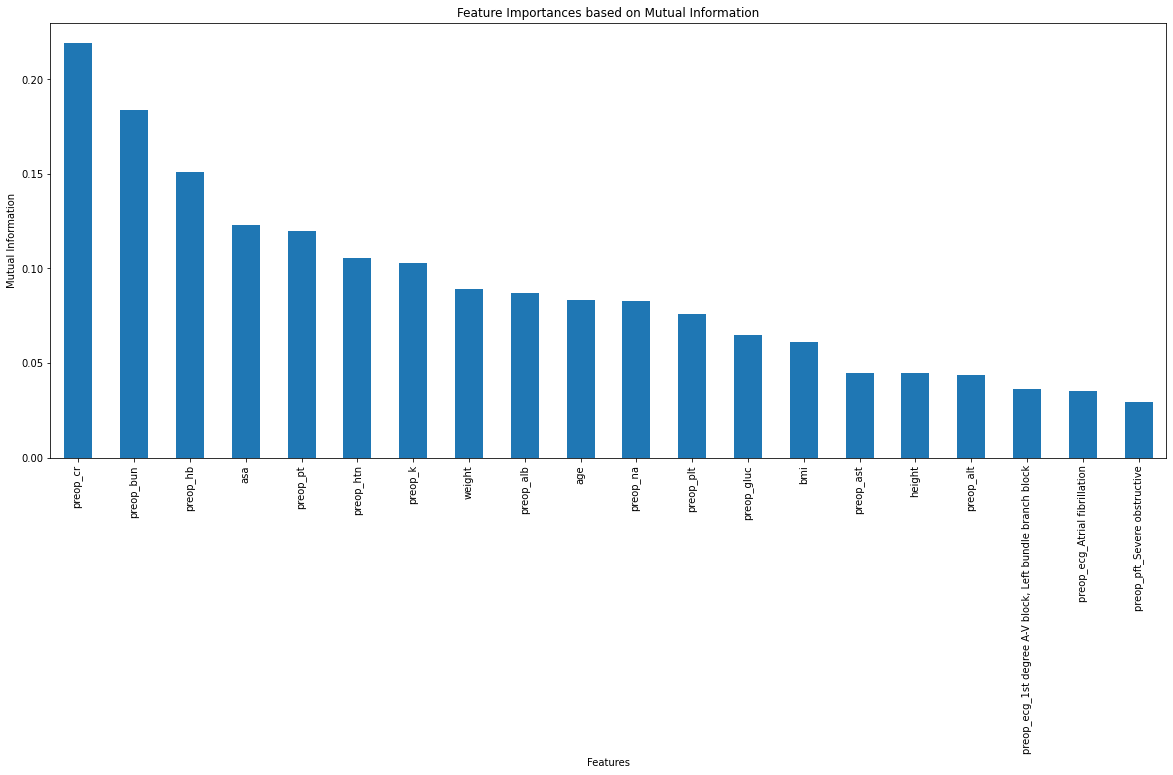

The accuracy for model xgboost for Top 10 is  0.33650793650793653
The accuracy for model Random Forest for Top 10 is  0.3619047619047619
10/10 [==============================] - 0s 10ms/step - loss: 2.0562 - acc: 0.2635
The accuracy for Neural Network for Top 10 is  0.26349207758903503


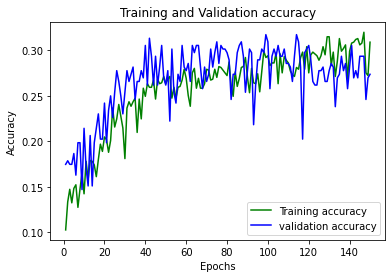

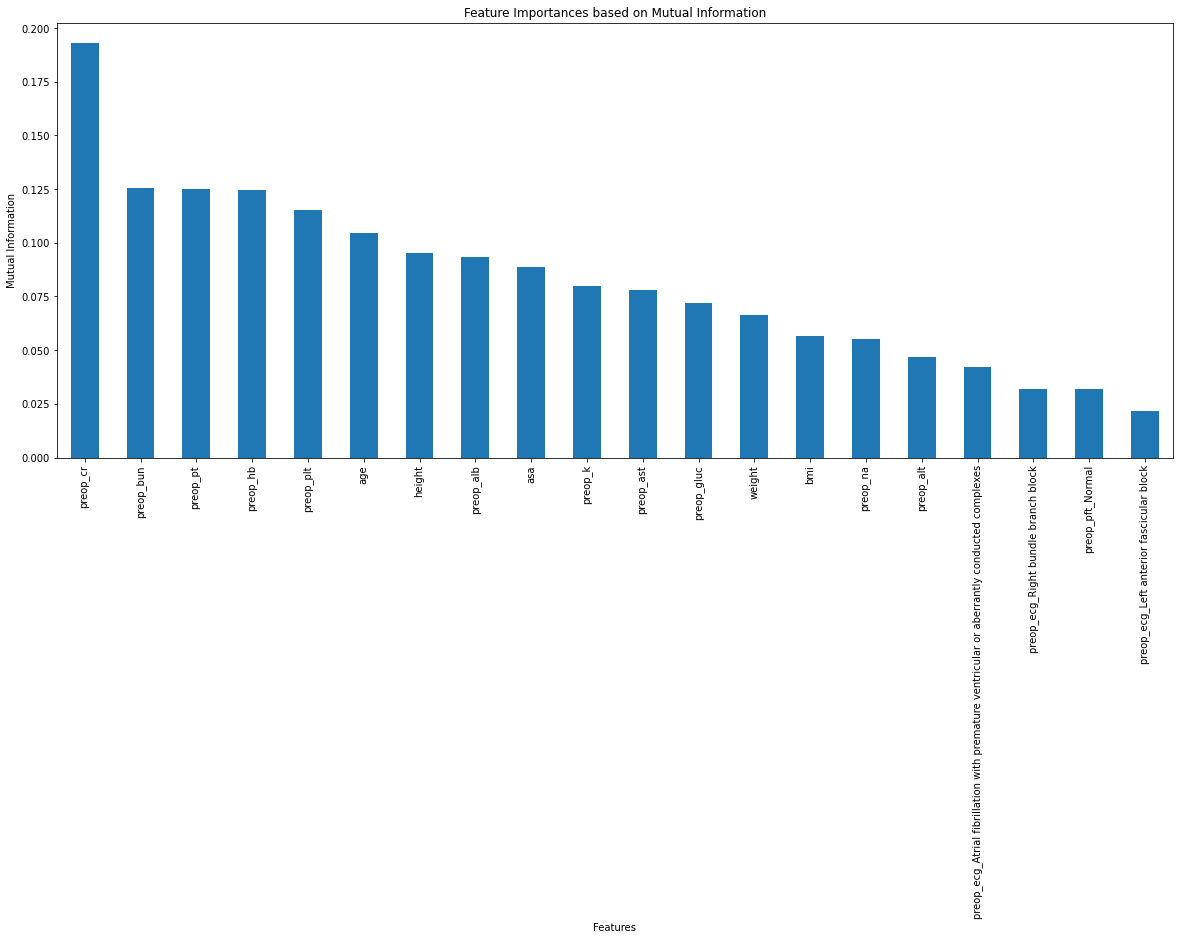

The accuracy for model xgboost for Top 25 is  0.15693430656934307
The accuracy for model Random Forest for Top 25 is  0.19708029197080293
18/18 [==============================] - 0s 10ms/step - loss: 3.3739 - acc: 0.1369
The accuracy for Neural Network for Top 25 is  0.13686130940914154


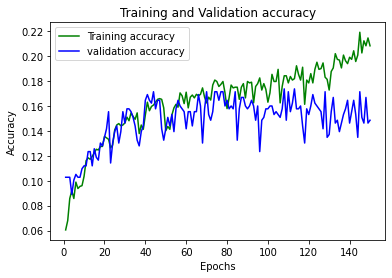

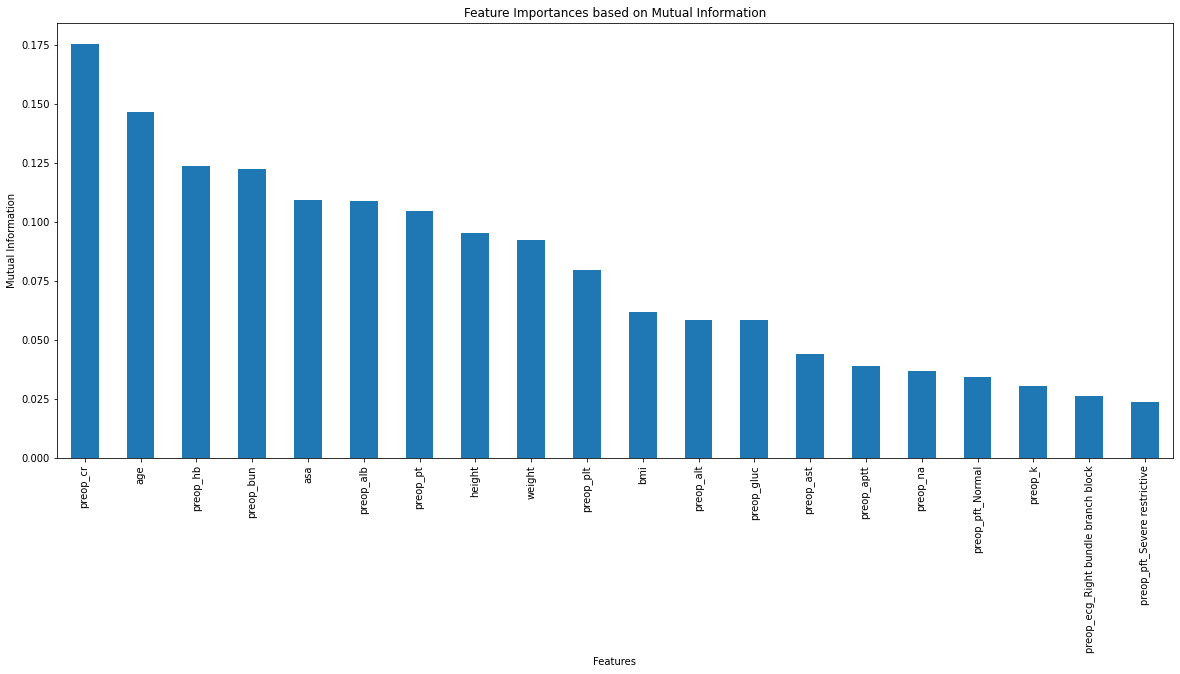

The accuracy for model xgboost for Top 50 is  0.13580246913580246
The accuracy for model Random Forest for Top 50 is  0.15775034293552812
23/23 [==============================] - 0s 10ms/step - loss: 7.0837 - acc: 0.0892
The accuracy for Neural Network for Top 50 is  0.08916323632001877


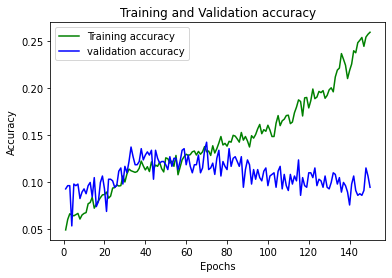

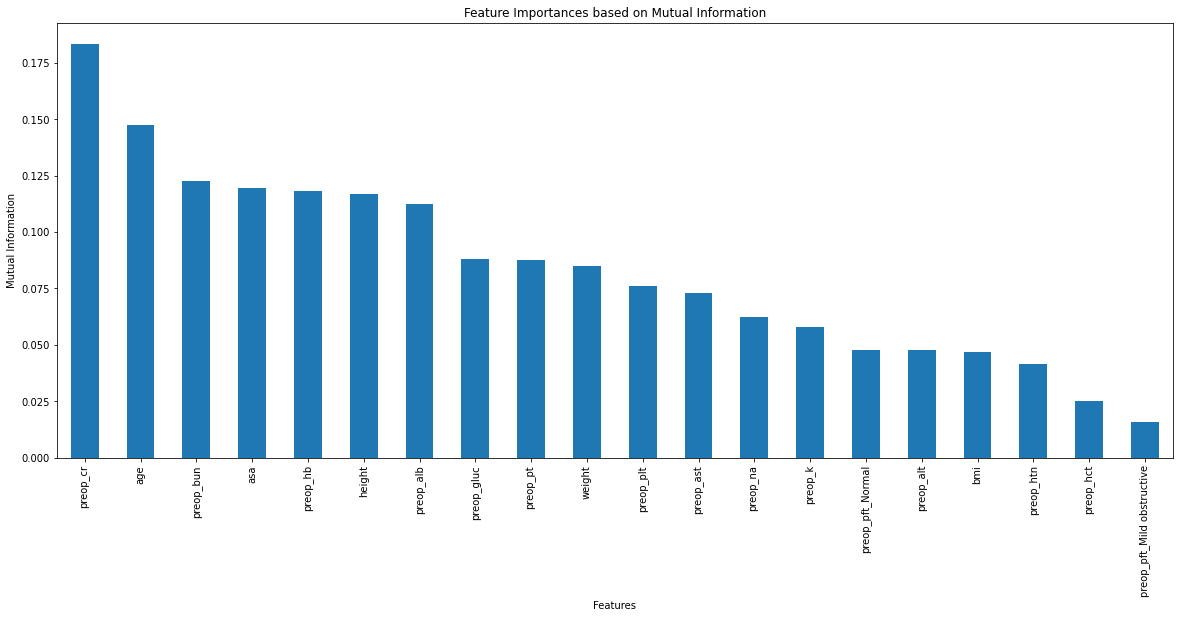

The accuracy for model xgboost for Top 75 is  0.11644657863145258
The accuracy for model Random Forest for Top 75 is  0.12484993997599039
27/27 [==============================] - 0s 10ms/step - loss: 5.5173 - acc: 0.0732
The accuracy for Neural Network for Top 75 is  0.07322929054498672


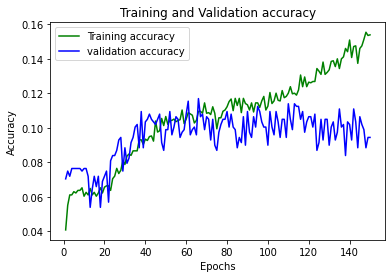

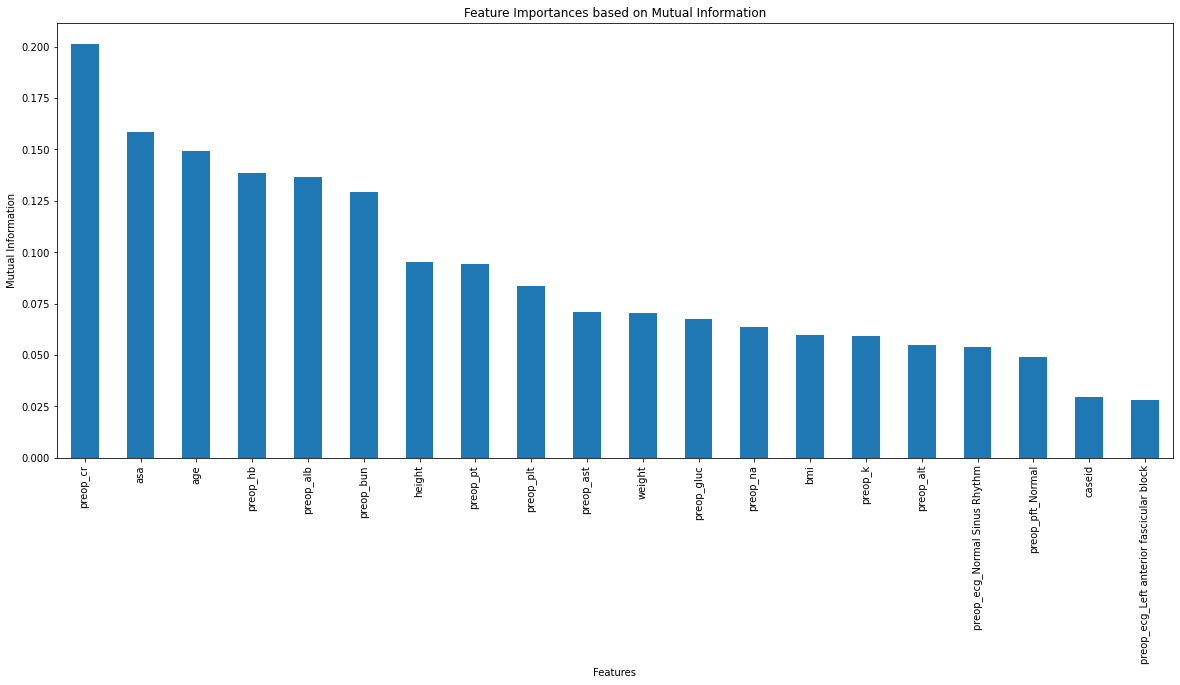

The accuracy for model xgboost for Top 100 is  0.11272321428571429
The accuracy for model Random Forest for Top 100 is  0.13169642857142858
28/28 [==============================] - 0s 10ms/step - loss: 5.6646 - acc: 0.0848
The accuracy for Neural Network for Top 100 is  0.0848214253783226


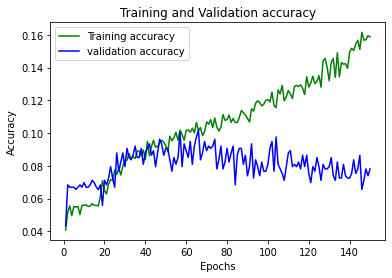

In [177]:
def model(data, name, targets):

    y = data['dx']
    x = data.drop(['dx'], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Constant Feature Check

    varThresh = VarianceThreshold(threshold=1)
    varThresh.fit(x_train)

    len(x_train.columns[varThresh.get_support()])

    # determine the mutual information
    mutual_info = mutual_info_classif(x_train, y_train)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = x_train.columns
    mutual_info.sort_values(ascending=False)

    #let's plot the ordered mutual_info values per feature
    # Plotting the features having highest importance to lowest
    mutual_info.sort_values(ascending=False)[:20].plot.bar(figsize=(20, 8))
    plt.title("Feature Importances based on Mutual Information")
    plt.xlabel("Features")
    plt.ylabel("Mutual Information")
    plt.savefig("graph" + name + ".png", bobx="tight", pad_inches=0)
    plt.show()

    # Now we Will select the  top 20 important features
    sel_cols = SelectKBest(chi2, k=45)
    sel_cols.fit(x_train, y_train)
    x_test = x_test[x_train.columns[sel_cols.get_support()]]
    x_train = x_train[x_train.columns[sel_cols.get_support()]]

    # Scale data

    # Logistic Regression Model
    # lrmodel = LogisticRegression(max_iter=1000)
    # lrmodel.fit(x_train, y_train) 
    # lrpred = lrmodel.predict(x_test)
    # print("The accuracy for model Logistioc Regression for " + name + " is ", accuracy_score(lrpred, y_test))

    # XGBoost Model
    xgb = XGBClassifier(max_depth=3)
    xgb.fit(x_train, y_train)
    xgbpred = xgb.predict(x_test)
    print("The accuracy for model xgboost for " + name + " is ", accuracy_score(xgbpred, y_test))

    # Random Forest Model
    rf = RandomForestClassifier(max_features = 5, n_estimators = 500)
    rf.fit(x_train, y_train)
    rfpred = rf.predict(x_test)
    print("The accuracy for model Random Forest for " + name + " is ", accuracy_score(rfpred, y_test))

    # ANN Model
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    model = ann_model(targets)
    history = model.fit(x_train, y_train, epochs=150, batch_size=100, validation_data=(x_val, y_val), verbose=0)
    _, acc = model.evaluate(x_test, y_test)
    print("The accuracy for Neural Network for " + name + " is ", acc)

    loss_train = history.history['acc']
    loss_val = history.history['val_acc']
    epochs = range(1,151)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("ann_plot_" + name + ".png", bobx="tight", pad_inches=0)
    plt.show()


data_list = ["Top 10", "Top 25", "Top 50", "Top 75", "Top 100"]
target_col = [10, 25, 50, 75, 100]
count = 0

for i in top_data_list:
    model(i, data_list[count], target_col[count])
    count += 1

### Hyperparameter Tuning for Random Forest


In [162]:
y = data_top_10['dx']
x = data_top_10.drop(['dx'], axis=1)

max_features = np.arange(5,10,1)
n_estimators = np.arange(100, 1100, 100)

param_grid = {
                'max_features': max_features,
                'n_estimators': n_estimators
            }

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           n_jobs = -1, verbose = 2)

grid_search.fit(x, y)
grid_search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'max_features': 5, 'n_estimators': 500}

In [163]:
grid_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_results.head()

,max_features,n_estimators,Accuracy
0,5,100,0.319126
1,5,200,0.335665
2,5,300,0.341387
3,5,400,0.346487
4,5,500,0.350931


In [164]:
grid_contour = grid_results.groupby(['max_features','n_estimators']).mean()
grid_contour

Accuracy
max_features n_estimators          
5            100           0.319126
             200           0.335665
             300           0.341387
             400           0.346487
             500           0.350931
             600           0.345848
             700           0.343937
             800           0.347122
             900           0.338851
             1000          0.344576
6            100           0.337580
             200           0.335659
             300           0.340756
             400           0.341393
             500           0.340744
             600           0.337578
             700           0.343937
             800           0.347761
             900           0.349651
             1000          0.342669
7            100           0.328058
             200           0.343298
             300           0.341405
             400           0.339494
             500           0.341395
             600           0.348396
             700           0.350925
             800           0.342024
             900           0.350300
             1000          0.344572
8            100           0.328052
             200           0.344576
             300           0.347112
             400           0.342671
             500           0.342032
             600           0.348398
             700           0.343306
             800           0.338217
             900           0.347755
             1000          0.343937
9            100           0.342010
             200           0.338229
             300           0.334393
             400           0.342026
             500           0.336941
             600           0.342026
             700           0.342659
             800           0.337576
             900           0.339486
             1000          0.343947

In [165]:
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['max_features', 'n_estimators', 'Accuracy']
grid_pivot = grid_reset.pivot('max_features', 'n_estimators')
grid_pivot

Accuracy                                                    \
n_estimators      100       200       300       400       500       600    
max_features                                                               
5             0.319126  0.335665  0.341387  0.346487  0.350931  0.345848   
6             0.337580  0.335659  0.340756  0.341393  0.340744  0.337578   
7             0.328058  0.343298  0.341405  0.339494  0.341395  0.348396   
8             0.328052  0.344576  0.347112  0.342671  0.342032  0.348398   
9             0.342010  0.338229  0.334393  0.342026  0.336941  0.342026   

                                                      
n_estimators      700       800       900       1000  
max_features                                          
5             0.343937  0.347122  0.338851  0.344576  
6             0.343937  0.347761  0.349651  0.342669  
7             0.350925  0.342024  0.350300  0.344572  
8             0.343306  0.338217  0.347755  0.343937  
9             0.342659  0.337576  0.339486  0.343947

In [166]:
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

In [168]:
import plotly.graph_objects as go

layout = go.Layout(
            xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
            text='n_estimators')
            ),
            yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
            text='max_features') 
            ))

fig = go.Figure(data=[go.Surface(z=z, y=y, x=x)], layout=layout)

fig.update_layout(  title='Hyperparameter tuning',
                    scene = dict(
                    xaxis_title='n_estimators',
                    yaxis_title='max_features',
                    zaxis_title='Accuracy'),
                    autosize=False,
                    width=800, height=800,
                    margin=dict(l=65, r=50, b=65, t=90))

fig.show()